# Distributed MCMC Retrieval

This notebook runs the MCMC retrievals on a local cluster using `ipyparallel`.


In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
lview = c.load_balanced_view()

## Retrieval Setup

In [2]:
%%px
%env ARTS_BUILD_PATH=/home/simonpf/build/arts
%env ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env OMP_NUM_THREADS=1

import sys
sys.path.insert(1,"/home/simonpf/src/atms_simulations/")
sys.path.insert(1, "/home/simonpf/src/typhon/")

import os
os.chdir("/home/simonpf/src/atms_simulations")

# This is important otherwise engines just crash.
import matplotlib; matplotlib.use("agg")

[stdout:0] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:1] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:2] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:3] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_simulations/:/home/simonpf/src/arts_clean/controlfiles
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: OMP_NUM_THREADS=1
[stdout:4] 
env: ARTS_BUILD_PATH=/home/simonpf/build/arts
env: ARTS_INCLUDE_PATH

In [3]:
from typhon.arts.workspace import Workspace
import atms
import numpy as np

ws = Workspace()
channels = [0,15,16,17,19]
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.yCalc()

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so
ARTS[37043520]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[37043520]: {
ARTS[37043520]: - verbosityInit
ARTS[37043520]: - scat_speciesSet
ARTS[37043520]: - MatrixSet
ARTS[37043520]: - Tensor4SetConstant
ARTS[37043520]: - ArrayOfStringSet
ARTS[37043520]: - Touch
ARTS[37043520]: - FlagOff
ARTS[37043520]: - MatrixSet
ARTS[37043520]: - NumericSet
ARTS[37043520]: - ArrayOfStringSet
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - Tensor3SetConstant
ARTS[37043520]: - IndexSet
ARTS[37043520]: - IndexSet
ARTS[37043520]: - IndexSet
ARTS[37043520]: - IndexSet
ARTS[37043520]: - FlagOff
ARTS[37043520]: - output_file_formatSetAscii
ARTS[37043520]: - StringSet
ARTS[37043520]: - IndexSet
ARTS[37043520]: - abs_lineshapeDefine
ARTS[37043520]: - NumericSet
A

In [4]:
%%px
from typhon.arts.workspace import Workspace
import atms
import numpy as np

ws = Workspace()
channels = [0,15,16,17,19]
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.yCalc()

[stdout:0] 
Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so
ARTS[34464688]: Executing /home/simonpf/src/arts_clean/controlfiles/general/general.arts
ARTS[34464688]: {
ARTS[34464688]: - verbosityInit
ARTS[34464688]: - scat_speciesSet
ARTS[34464688]: - MatrixSet
ARTS[34464688]: - Tensor4SetConstant
ARTS[34464688]: - ArrayOfStringSet
ARTS[34464688]: - Touch
ARTS[34464688]: - FlagOff
ARTS[34464688]: - MatrixSet
ARTS[34464688]: - NumericSet
ARTS[34464688]: - ArrayOfStringSet
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - Tensor3SetConstant
ARTS[34464688]: - IndexSet
ARTS[34464688]: - IndexSet
ARTS[34464688]: - IndexSet
ARTS[34464688]: - IndexSet
ARTS[34464688]: - FlagOff
ARTS[34464688]: - output_file_formatSetAscii
ARTS[34464688]: - StringSet
ARTS[34464688]: - IndexSet
ARTS[34464688]: - abs_lineshapeDefine
ARTS[3446468

## A Priori State

The simulations are based on the a priori assumptions, that the profiles of specific humidity, temperature and ozone vary independently and that the relative variations can be described by Log-Gaussian distributions.

In [5]:
%%px
t_mean = np.load("data/t_mean.npy").ravel()
q_mean = np.load("data/q_mean.npy").ravel()
qt_mean = np.load("data/qt_mean.npy").ravel()
q_log_mean = np.load("data/q_log_mean.npy").ravel()

In [6]:
%%px
t_cov     = np.load("data/t_cov.npy")
q_cov     = np.load("data/q_log_cov.npy")
qt_cov     = np.load("data/qt_cov.npy")


In [7]:
%%px
t_cov_inv  = np.linalg.inv(t_cov)
q_cov_inv  = np.linalg.inv(q_cov)
qt_cov_inv  = np.linalg.inv(qt_cov)

## Jumping Functions

The jumping functions are used inside the MCMC iteration and propose new atmospheric states for specific humidity, temperature and ozone, respectively. The proposed states are generated from random walks that use scaled versions of the a priori covariances.

In [8]:
%%px
import numpy as np
from typhon.retrieval.mcmc import RandomWalk
c = (2.4 / np.sqrt(q_mean.size)) ** 2
c2 = (1.0 / np.sqrt(qt_mean.size)) ** 2

rw_t   = RandomWalk(c * t_cov)
rw_q   = RandomWalk(c * q_cov)
rw_qt  = RandomWalk(c2 * qt_cov)

def j_t(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_t.step(x)
    ws.t_field.value[:, 0, 0] = x_new[::-1]
    return x_new

def j_q(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_q.step(x)
    q_new = (np.exp(x_new).reshape(q_mean.shape))[::-1]
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    return x_new

def j_qt(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_qt.step(x)
    q_new = (np.exp(x_new[14::-1]).reshape((15,)))
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    ws.t_field.value[:, 0, 0] = x_new[:14:-1]
    return x_new

## A Priori Distributions

These functions return the likelihood (up to an additive constant) of a given state for each of the variables. Note that the states of specific humidity, temperature and ozone are given by the logs of the relative variations. 

In [9]:
%%px
def p_a_t(x):
    dx = x - t_mean
    l = - 0.5 * np.dot(dx, np.dot(t_cov_inv, dx))
    return l

def p_a_q(x):
    dx = x - q_log_mean
    l = - 0.5 * np.dot(dx, np.dot(q_cov_inv, dx))
    return l

def p_a_qt(x):
    dx = x - qt_mean
    l = - 0.5 * np.dot(dx, np.dot(qt_cov_inv, dx))
    return l

## Measurement Uncertainty

We assume that uncertainty of the measured brightness temperatures can be described by independent Gaussian error with a standard deviation of $1 K$.

In [10]:
%%px
covmat_y = np.diag(np.ones(len(channels)))
covmat_y_inv = np.linalg.inv(covmat_y)

def p_y(y, yf):
    dy = y - yf
    l  = - 0.5 * np.dot(dy, np.dot(covmat_y_inv, dy))
    return l

# Running MCMC


### The Simulated Measurement

For the simulated measurement, we sample a state from the a priori distribution of atmsopheric states and simulate the measured brightness temperatures.

A simple heuristic is applied to ensure that reasonable acceptance rates are obtained during the MCMC simulations. After the initial burn-in phase, 1000 simulation steps are performed. If the acceptance rates during this simulation are too low/high that covariance matrices of the corresponding random walks are scaled by a factor 0.1 / 9.0, respectively.

In [11]:
%%px
def adapt_covariances(a):
    # qt
    if (np.sum(a[:, 0]) / a.shape[0]) < 0.2:
        rw_q.covmat *= 0.7
    if (np.sum(a[:, 0]) / a.shape[0]) > 0.4:
        rw_q.covmat *= 1.5
#    # t 
#    if (np.sum(a[:, 1]) / a.shape[0]) < 0.2:
#        rw_t.covmat *= 0.3
#    if (np.sum(a[:, 1]) / a.shape[0]) > 0.4:
#        rw_t.covmat *= 3.0

In [12]:
%%px
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

dist = atms.StateDistribution()
n_burn_in = 1000
n_prod    = 10000
drop      = 50

In [13]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

def run_retrieval(i):
    
    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))

    # Generate True State
    dist.sample(ws)
    ws.yCalc()
    y_true   = np.copy(ws.y)
    q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
    t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
    cwv_true = atms.vmr2cd(ws)
    
    dist.a_priori(ws)
    q = np.zeros(q_mean.size)
    t = np.zeros(t_mean.size)
    qt = np.zeros(qt_mean.size)

    # Add Noise
    y_true += np.random.randn(*y_true.shape)
    
    #try:
    mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_1, s_1, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_2, s_2, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_3, s_3, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_4, s_4, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_5, s_5, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_6, s_6, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_7, s_7, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt   = RandomWalk(np.copy(c2 * q_cov))
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 500)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_8, s_8, _, _ = mcmc.run(ws, n_prod)

    profiles_q =  np.stack([hist_1[0][::drop, :15],
                            hist_2[0][::drop, :15],
                            hist_3[0][::drop, :15],
                            hist_4[0][::drop, :15],
                            hist_5[0][::drop, :15],
                            hist_6[0][::drop, :15],
                            hist_7[0][::drop, :15],
                            hist_8[0][::drop, :15]])
    profiles_t =  np.stack([hist_1[0][::drop, 15:],
                            hist_2[0][::drop, 15:],
                            hist_3[0][::drop, 15:],
                            hist_4[0][::drop, 15:],
                            hist_5[0][::drop, 15:],
                            hist_6[0][::drop, 15:],
                            hist_7[0][::drop, 15:],
                            hist_8[0][::drop, 15:]])
    cwv = np.stack([s_1[::drop], s_2[::drop], s_3[::drop], s_4[::drop],
                    s_5[::drop],s_6[::drop],s_7[::drop],s_8[::drop]], axis=0)
    return y_true, q_true, cwv_true, profiles_q, profiles_t, cwv
#    except:
#        
#        rw_q   = RandomWalk(np.copy(c * q_cov))
#        rw_t   = RandomWalk(np.copy(c * t_cov))
#        
#        return (None, y_true, q, t_true, cwv_true)
    


## Running the Retrievals

In [14]:
import numpy as np
ids = np.arange(1000)
rs = lview.map_async(run_retrieval, ids)

In [ ]:
from atms import create_output_file

profs_q = np.zeros((1000, 1600, 15))
profs_t = np.zeros((1000, 1600, 15))

root_group, v_y_true, v_cwv_true, v_cwv ,v_h2o = create_output_file("data/mcmc_retrievals_5.nc", 5, 15)
for y_true, h2o_true, cwv_true, profiles_q, profiles_t, cwv in rs:
    if not y_true is None:
        t = v_cwv_true.shape[0]
        print("saving simulation: " + str(t))
        profs_q[t, :, :] = profiles_q.reshape(-1, 15)
        profs_t[t, :, :] = profiles_t.reshape(-1, 15)
        steps=cwv.size
        v_y_true[t,:]      = y_true
        ws.vmr_field.value[0,:,:,:] = h2o_true.reshape(-1,1,1)
        v_cwv_true[t]      = cwv_true
        v_cwv[t, :steps]   = cwv[:]
        v_h2o[t, :steps,:] = profiles_q.ravel().reshape(-1, 15)
    else:
        print("failure in simulation: " + str(t))
        print(h2o_true)
        print(cwv_true)
        print(profiles)

loading existing file: data/mcmc_retrievals_5.nc
saving simulation: 40
saving simulation: 41
saving simulation: 42
saving simulation: 43
saving simulation: 44
saving simulation: 45
saving simulation: 46
saving simulation: 47
saving simulation: 48
saving simulation: 49
saving simulation: 50
saving simulation: 51
saving simulation: 52
saving simulation: 53
saving simulation: 54
saving simulation: 55
saving simulation: 56
saving simulation: 57
saving simulation: 58
saving simulation: 59
saving simulation: 60
saving simulation: 61
saving simulation: 62
saving simulation: 63
saving simulation: 64
saving simulation: 65
saving simulation: 66
saving simulation: 67
saving simulation: 68
saving simulation: 69
saving simulation: 70
saving simulation: 71
saving simulation: 72
saving simulation: 73
saving simulation: 74
saving simulation: 75
saving simulation: 76
saving simulation: 77
saving simulation: 78
saving simulation: 79
saving simulation: 80
saving simulation: 81
saving simulation: 82
savin

saving simulation: 397
saving simulation: 398
saving simulation: 399
saving simulation: 400
saving simulation: 401
saving simulation: 402
saving simulation: 403
saving simulation: 404
saving simulation: 405
saving simulation: 406
saving simulation: 407
saving simulation: 408
saving simulation: 409
saving simulation: 410
saving simulation: 411
saving simulation: 412
saving simulation: 413
saving simulation: 414
saving simulation: 415
saving simulation: 416
saving simulation: 417
saving simulation: 418
saving simulation: 419
saving simulation: 420
saving simulation: 421
saving simulation: 422
saving simulation: 423
saving simulation: 424
saving simulation: 425
saving simulation: 426
saving simulation: 427
saving simulation: 428
saving simulation: 429
saving simulation: 430
saving simulation: 431
saving simulation: 432
saving simulation: 433
saving simulation: 434
saving simulation: 435
saving simulation: 436
saving simulation: 437
saving simulation: 438
saving simulation: 439
saving simu

saving simulation: 754
saving simulation: 755
saving simulation: 756
saving simulation: 757
saving simulation: 758
saving simulation: 759
saving simulation: 760
saving simulation: 761
saving simulation: 762
saving simulation: 763
saving simulation: 764
saving simulation: 765
saving simulation: 766
saving simulation: 767
saving simulation: 768
saving simulation: 769
saving simulation: 770
saving simulation: 771
saving simulation: 772
saving simulation: 773
saving simulation: 774
saving simulation: 775
saving simulation: 776
saving simulation: 777
saving simulation: 778
saving simulation: 779
saving simulation: 780
saving simulation: 781
saving simulation: 782
saving simulation: 783
saving simulation: 784
saving simulation: 785
saving simulation: 786
saving simulation: 787
saving simulation: 788
saving simulation: 789
saving simulation: 790
saving simulation: 791
saving simulation: 792
saving simulation: 793
saving simulation: 794
saving simulation: 795
saving simulation: 796
saving simu

In [58]:
import matplotlib_settings
import matplotlib.pyplot as plt

In [21]:

root_group, v_y_true, v_cwv_true, v_cwv ,v_h2o = create_output_file("data/mcmc_retrievals_5.nc", 5, 27)

loading existing file: data/mcmc_retrievals_5.nc


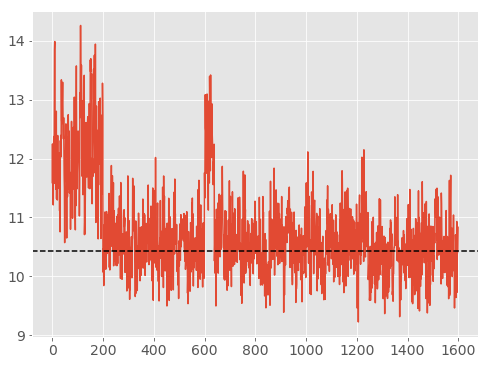

In [124]:
for i in range(1, 2):
    plt.plot(v_cwv[i, :])
    plt.gca().axhline(v_cwv_true[i], c = 'k', ls = '--')

In [107]:
v_h2o[118, 250:500, :].shape

(250, 15)

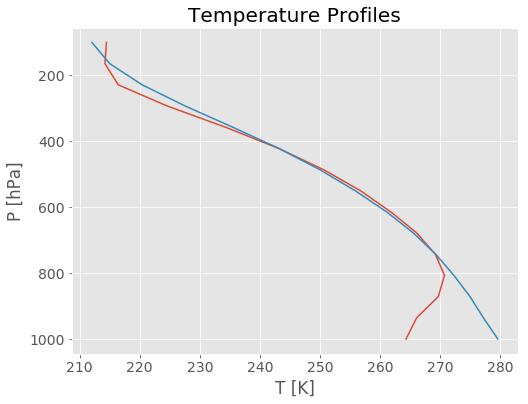

In [142]:
plt.plot(np.mean(profs_t[1, 0:200], axis = 0), p)
plt.plot(np.mean(profs_t[1, 200:400], axis = 0), p)
plt.title("Temperature Profiles")
plt.xlabel("T [K]")
plt.ylabel("P [hPa]")
plt.gca().invert_yaxis()

In [131]:
p = np.load("data/p_grid.npy")
profiles_t[1, :, :].shape

(200, 15)

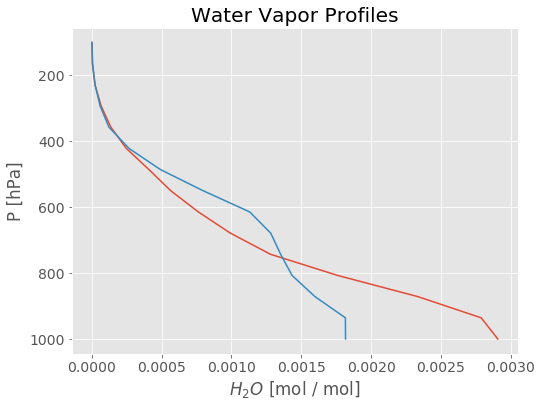

In [145]:
plt.plot(np.mean(np.exp(profs_q[1, 0:200]) * 18.0 / 28.9, axis = 0), p)
plt.plot(np.mean(np.exp(profs_q[1, 200:400]) * 18.0/ 28.9, axis = 0), p)
plt.gca().invert_yaxis()
plt.title("Water Vapor Profiles")
plt.xlabel("$H_2O$ [mol / mol]")
plt.ylabel("P [hPa]")